In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from functools import partial
import torchvision
from tqdm import trange, tqdm
import os 
import glob
import time
import copy
import random
from PIL import Image, ImageOps, ImageFilter

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device('cpu')

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
import sys
sys.path.append('../')

In [4]:
import re
import pandas as pd
import einops
from os.path import join
from tqdm import trange, tqdm
from os.path import join
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent

In [5]:
def batch_load_samples(samples_dir, epoch_list, encoding="onehot", fmt="tensor%s.pt"):
    sample_all = []
    for epoch in tqdm(epoch_list): 
        if not os.path.exists(join(samples_dir, fmt % epoch)):
            print(epoch, "not exist")
            break
        samples = torch.load(join(samples_dir, fmt % epoch)) # (batch, 27, 9, 9)
        if encoding == "onehot":
            attr_tsr_list = onehot2attr_tsr(samples, threshold=0.5)
        elif encoding == "digit":
            attr_tsr_list = torch.round(samples).int() # (batch, 3, 9, 9)
        else:
            raise ValueError("encoding should be onehot or digit")
        sample_all.append(attr_tsr_list)
    return sample_all

### Loading

In [6]:
figdir = "../Figures"

In [11]:
!ls $STORE_DIR/DL_Projects/DiT/results

000-RAVEN10_abstract-DiT_S_1
001-RAVEN10_abstract-DiT_B_1
002-RAVEN10_abstract-DiT_S_1
003-RAVEN10_abstract_onehot-DiT_S_1
004-RAVEN10_abstract-DiT_S_1
005-RAVEN10_abstract_onehot-DiT_S_1
006-RAVEN10_abstract-DiT_S_1
007-RAVEN10_abstract_onehot-DiT_S_1
008-RAVEN10_abstract-DiT_S_3
009-RAVEN10_abstract-DiT_S_1
010-RAVEN10_abstract-DiT_L_1
011-RAVEN10_abstract-DiT_B_1
012-RAVEN10_abstract-DiT_B_3
013-RAVEN10_abstract-DiT_S_3
014-RAVEN10_abstract_onehot-DiT_S_3
015-RAVEN10_abstract_onehot-DiT_B_3
016-RAVEN10_abstract-DiT_S_3
017-RAVEN10_abstract_onehot-DiT_S_1
018-RAVEN10_abstract-DiT_S_1
019-RAVEN10_abstract_onehot-DiT_S_1
020-RAVEN10_abstract-DiT_S_1
021-RAVEN10_abstract-uncond-DiT_S_3_20240308-1349
022-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1349
023-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1349
024-RAVEN10_abstract-uncond-DiT_B_3_20240308-1349
025-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1349
026-RAVEN10_abstract-cond-DiT_S_3_20240308-1349
027-RAVEN10_abstract-unco

In [13]:
!ls $STORE_DIR/DL_Projects/DiT/results/041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718/samples

0001000.pt  0078000.pt	0155000.pt  0232000.pt	0309000.pt  0386000.pt
0002000.pt  0079000.pt	0156000.pt  0233000.pt	0310000.pt  0387000.pt
0003000.pt  0080000.pt	0157000.pt  0234000.pt	0311000.pt  0388000.pt
0004000.pt  0081000.pt	0158000.pt  0235000.pt	0312000.pt  0389000.pt
0005000.pt  0082000.pt	0159000.pt  0236000.pt	0313000.pt  0390000.pt
0006000.pt  0083000.pt	0160000.pt  0237000.pt	0314000.pt  0391000.pt
0007000.pt  0084000.pt	0161000.pt  0238000.pt	0315000.pt  0392000.pt
0008000.pt  0085000.pt	0162000.pt  0239000.pt	0316000.pt  0393000.pt
0009000.pt  0086000.pt	0163000.pt  0240000.pt	0317000.pt  0394000.pt
0010000.pt  0087000.pt	0164000.pt  0241000.pt	0318000.pt  0395000.pt
0011000.pt  0088000.pt	0165000.pt  0242000.pt	0319000.pt  0396000.pt
0012000.pt  0089000.pt	0166000.pt  0243000.pt	0320000.pt  0397000.pt
0013000.pt  0090000.pt	0167000.pt  0244000.pt	0321000.pt  0398000.pt
0014000.pt  0091000.pt	0168000.pt  0245000.pt	0322000.pt  0399000.pt
0015000.pt  0092000.pt	0169000.pt 

In [17]:
!cd $STORE_DIR/DL_Projects/DiT/results/041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718/samples; pwd

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718/samples


In [8]:
!ls $STORE_DIR/DL_Projects/mini_edm/exps/

BaseBlnr_RAVEN10_abstract_20240212-2142
BaseBlnr_RAVEN10_abstract_onehot_20240212-2143
base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
Base_RAVEN10_abstract_20240212-2139
base_RAVEN10_abstract_onehot_20240201-0147
Base_RAVEN10_abstract_onehot_20240212-2140
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
Big_RAVEN10_abstract_20240207-1925
Big_RAVEN10_abstract_onehot_20240207-1925
WideBlnr_RAVEN10_abstract_20240211-1747
WideBlnr_RAVEN10_abstract_onehot_20240211-1743
Wide_RAVEN10_abstract_20240206-2323
Wide_RAVEN10_abstract_onehot_20240206-2324


In [8]:
!ls $STORE_DIR/DL_Projects/mini_edm/exps/Base_RAVEN10_abstract_20240212-2139


checkpoints	 samples				std.log
dataset_idx.pkl  samples_inferred_rule_consistency.npz


In [9]:
!ls $WORK_DIR/Datasets

2020-BigGAN.zip      ffhq-64x64.zip	 imagenet-valid        Stimuli
2021-EvolDecomp.zip  GAN_sample_fid.zip  img_align_celeba.zip  stl10_binary
cifar10.zip	     Imagenet64_val.zip  Mat_Statistics


In [11]:
!ls $STORE_DIR/DL_Projects/mini_edm/exps/Base_RAVEN10_abstract_20240212-2139

checkpoints	 samples				std.log
dataset_idx.pkl  samples_inferred_rule_consistency.npz


In [12]:
!echo $STORE_DIR

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang


In [37]:
train_attrs = torch.load("../train_inputs.pt")

In [14]:
train_attrs.shape

torch.Size([35, 10000, 3, 9, 3])

In [15]:
sample_dir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/Base_RAVEN10_abstract_20240212-2139/samples"
sample_all = batch_load_samples(sample_dir, range(0,100000,5000), encoding="digit")

100%|██████████| 20/20 [00:00<00:00, 112.00it/s]


In [16]:
attr_panels = einops.rearrange(sample_all[-1], 'b attr (row h) (p w) -> (b row) p (h w) attr', row=3, p=3)
attr_panels.shape # (batch*3, 3, 9, 3)

torch.Size([6144, 3, 9, 3])

In [17]:
data = train_attrs.to(device).to(int)

In [38]:
(data - attr_panels[1].to(device)).abs().sum(dim=(-1,-2,-3))

tensor([[161, 178, 252,  ..., 230, 316, 161],
        [344, 309, 200,  ..., 329, 271, 245],
        [250, 213, 293,  ..., 195, 188, 201],
        ...,
        [291, 306, 295,  ..., 306, 225, 188],
        [323, 242, 231,  ..., 176, 294, 210],
        [201, 212, 200,  ..., 194, 275, 228]])

In [39]:
L1dist = (data - attr_panels[1].to(device)).abs().sum(dim=(-1,-2,-3))

In [23]:
attr_panels = einops.rearrange(sample_all[-1], 'b attr (row h) (p w) -> (b row) p (h w) attr', row=3, p=3)
attr_panels.shape # (batch*3, 3, 9, 3)

minL1dist_mat = []
minimum_vec = []
batchsize = 16
for i in trange(0,len(attr_panels),batchsize):
    L1dist = (data[None,] - attr_panels[i:i+batchsize].to(device)[:,None,None]).abs().sum(dim=(-1,-2,-3))
    minL1dist = L1dist.min(dim=-1).values
    minimum = minL1dist.min(dim=-1).values
    minL1dist_mat.append(minL1dist)
    minimum_vec.append(minimum)

minL1dist_mat = torch.concatenate(minL1dist_mat, dim=0)
minimum_vec = torch.concatenate(minimum_vec, dim=0)

100%|██████████| 384/384 [14:49<00:00,  2.32s/it]


In [1]:
minL1dist_mat.shape

NameError: name 'minL1dist_mat' is not defined

In [22]:
torch.concatenate(minL1dist_mat, dim=0)

tensor([[205, 234, 204,  ..., 187, 221, 212],
        [122, 158, 109,  ...,  97, 171, 118],
        [224, 220, 210,  ..., 218, 216, 216],
        ...,
        [201, 218, 204,  ..., 201, 216, 209],
        [223, 177, 179,  ..., 194, 213, 202],
        [158, 187, 196,  ..., 191, 194, 175]])

In [47]:
attr_panels[i:i+batchsize].shape

torch.Size([512, 3, 9, 3])

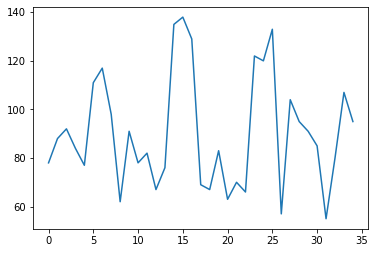

In [43]:
plt.plot(L1dist.min(dim=1).values)

### DiT sample check

In [18]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/

000-RAVEN10_abstract-DiT_S_1
001-RAVEN10_abstract-DiT_B_1
002-RAVEN10_abstract-DiT_S_1
003-RAVEN10_abstract_onehot-DiT_S_1
004-RAVEN10_abstract-DiT_S_1
005-RAVEN10_abstract_onehot-DiT_S_1
006-RAVEN10_abstract-DiT_S_1
007-RAVEN10_abstract_onehot-DiT_S_1
008-RAVEN10_abstract-DiT_S_3
009-RAVEN10_abstract-DiT_S_1
010-RAVEN10_abstract-DiT_L_1
011-RAVEN10_abstract-DiT_B_1
012-RAVEN10_abstract-DiT_B_3
013-RAVEN10_abstract-DiT_S_3
014-RAVEN10_abstract_onehot-DiT_S_3
015-RAVEN10_abstract_onehot-DiT_B_3
016-RAVEN10_abstract-DiT_S_3
017-RAVEN10_abstract_onehot-DiT_S_1
018-RAVEN10_abstract-DiT_S_1
019-RAVEN10_abstract_onehot-DiT_S_1
020-RAVEN10_abstract-DiT_S_1
021-RAVEN10_abstract-uncond-DiT_S_3_20240308-1349
022-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1349
023-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1349
024-RAVEN10_abstract-uncond-DiT_B_3_20240308-1349
025-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1349
026-RAVEN10_abstract-cond-DiT_S_3_20240308-1349
027-RAVEN10_abstract-unco

In [7]:
train_attrs = torch.load("../train_inputs.pt")

In [31]:
sample_dir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718/samples'

In [26]:
sample_dir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718/samples'

In [27]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718/samples

0001000.pt  0078000.pt	0155000.pt  0232000.pt	0309000.pt  0386000.pt
0002000.pt  0079000.pt	0156000.pt  0233000.pt	0310000.pt  0387000.pt
0003000.pt  0080000.pt	0157000.pt  0234000.pt	0311000.pt  0388000.pt
0004000.pt  0081000.pt	0158000.pt  0235000.pt	0312000.pt  0389000.pt
0005000.pt  0082000.pt	0159000.pt  0236000.pt	0313000.pt  0390000.pt
0006000.pt  0083000.pt	0160000.pt  0237000.pt	0314000.pt  0391000.pt
0007000.pt  0084000.pt	0161000.pt  0238000.pt	0315000.pt  0392000.pt
0008000.pt  0085000.pt	0162000.pt  0239000.pt	0316000.pt  0393000.pt
0009000.pt  0086000.pt	0163000.pt  0240000.pt	0317000.pt  0394000.pt
0010000.pt  0087000.pt	0164000.pt  0241000.pt	0318000.pt  0395000.pt
0011000.pt  0088000.pt	0165000.pt  0242000.pt	0319000.pt  0396000.pt
0012000.pt  0089000.pt	0166000.pt  0243000.pt	0320000.pt  0397000.pt
0013000.pt  0090000.pt	0167000.pt  0244000.pt	0321000.pt  0398000.pt
0014000.pt  0091000.pt	0168000.pt  0245000.pt	0322000.pt  0399000.pt
0015000.pt  0092000.pt	0169000.pt 

In [8]:

DiTroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
sample_dir = DiTroot + "/042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718/samples"
sample_all = batch_load_samples(sample_dir, range(1000,1000000,1000), encoding="digit", fmt='%07d.pt')

  0%|          | 0/999 [00:00<?, ?it/s]

 47%|████▋     | 465/999 [00:00<00:00, 562.72it/s]

466000 not exist


In [14]:
epoch_list = range(1000,1000000,1000)
epoch_list = epoch_list[:len(sample_all)]

In [34]:
device = torch.device('cuda:0')
train_attrs = train_attrs.to(device).to(torch.int32)

#### Row wise rule check

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:02<00:00, 27.44it/s]


count    3072.000000
mean      119.237305
std        52.511325
min        18.000000
25%        97.000000
50%       117.000000
75%       132.000000
max       989.000000
dtype: float64


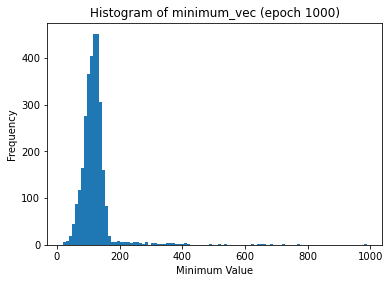

100%|██████████| 64/64 [00:02<00:00, 27.73it/s]


count    3072.000000
mean      112.518880
std        28.755059
min         8.000000
25%        93.000000
50%       116.000000
75%       134.000000
max       182.000000
dtype: float64


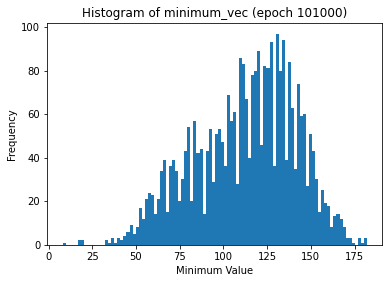

100%|██████████| 64/64 [00:02<00:00, 27.73it/s]


count    3072.000000
mean      112.108724
std        26.807645
min        14.000000
25%        93.000000
50%       116.000000
75%       132.000000
max       183.000000
dtype: float64


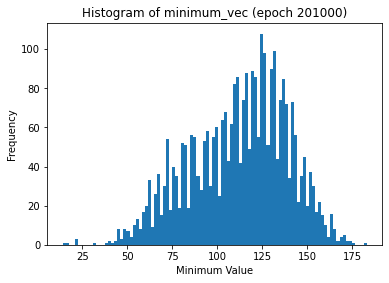

100%|██████████| 64/64 [00:02<00:00, 27.73it/s]


count    3072.000000
mean      116.861654
std        26.291147
min        11.000000
25%       100.000000
50%       121.000000
75%       136.000000
max       179.000000
dtype: float64


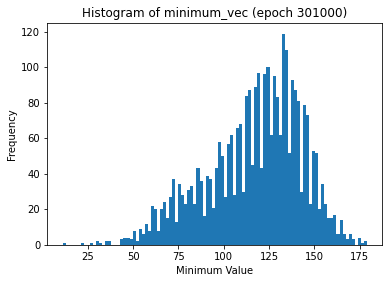

100%|██████████| 64/64 [00:02<00:00, 27.73it/s]


count    3072.000000
mean      109.668620
std        27.702228
min        16.000000
25%        90.000000
50%       114.000000
75%       131.000000
max       181.000000
dtype: float64


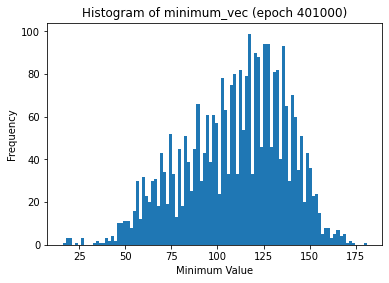

100%|██████████| 64/64 [00:02<00:00, 27.73it/s]


count    3072.000000
mean      111.776042
std        27.210050
min        20.000000
25%        93.000000
50%       115.000000
75%       132.000000
max       180.000000
dtype: float64


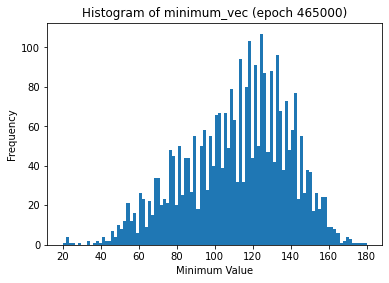

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
for epochi in [0, 100, 200, 300, 400, -1]:
    attr_panels = einops.rearrange(sample_all[epochi], 
            'b attr (row h) (p w) -> (b row) p (h w) attr', row=3, p=3)
    attr_panels.shape # (batch*3, 3, 9, 3)

    minL1dist_mat = []
    minimum_vec = []
    batchsize = 48
    for i in trange(0,len(attr_panels),batchsize):
        L1dist = (train_attrs[None,] - attr_panels[i:i+batchsize].to(device)[:,None,None]).abs().sum(dim=(-1,-2,-3))
        minL1dist = L1dist.min(dim=-1).values
        minimum = minL1dist.min(dim=-1).values
        minL1dist_mat.append(minL1dist)
        minimum_vec.append(minimum)

    minL1dist_mat = torch.concatenate(minL1dist_mat, dim=0).cpu() # (3 * sampleN, 35)
    minimum_vec = torch.concatenate(minimum_vec, dim=0).cpu() # (3 * sampleN,)
    # print basic statistics of minimum_vec using pandas
    print(pd.Series(minimum_vec.numpy()).describe())
    plt.hist(minimum_vec, bins=100)
    plt.xlabel('Minimum Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of minimum_vec (epoch {epoch_list[epochi]})')
    plt.show()

In [56]:
train_attrs.shape

torch.Size([35, 10000, 3, 9, 3])

In [57]:
train_attrs.shape

torch.Size([35, 10000, 3, 9, 3])

In [60]:
print(attr_one_panel.shape)

torch.Size([9216, 9, 3])
torch.Size([35, 30000, 9, 3])


In [33]:
attr_one_panel.dtype

torch.int32

torch.Size([35, 30000, 9, 3])
torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 26.08it/s]


count    9216.000000
mean       15.864800
std        28.414133
min         0.000000
25%         5.000000
50%        12.000000
75%        21.000000
max       877.000000
dtype: float64


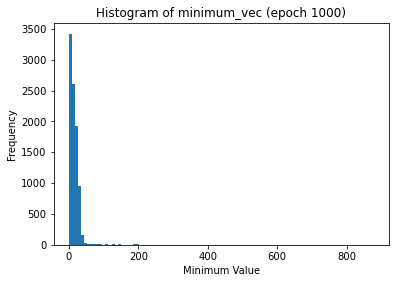

torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 24.30it/s]


count    9216.000000
mean       12.181532
std         9.653865
min         0.000000
25%         4.000000
50%        11.000000
75%        19.000000
max        47.000000
dtype: float64


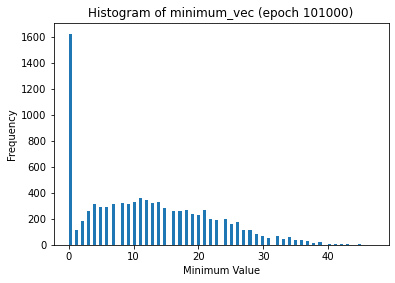

torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 24.30it/s]


count    9216.000000
mean       11.936849
std         9.458464
min         0.000000
25%         4.000000
50%        11.000000
75%        18.000000
max        44.000000
dtype: float64


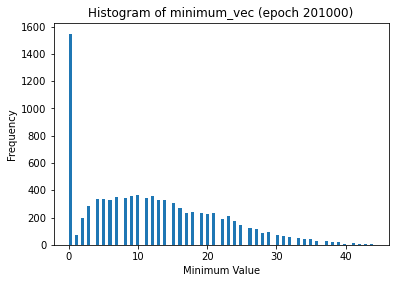

torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 24.29it/s]


count    9216.000000
mean       13.303277
std         9.718620
min         0.000000
25%         5.000000
50%        12.000000
75%        20.000000
max        45.000000
dtype: float64


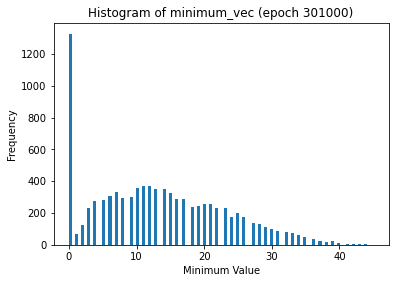

torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 24.30it/s]


count    9216.000000
mean       11.486111
std         9.340977
min         0.000000
25%         3.000000
50%        11.000000
75%        18.000000
max        44.000000
dtype: float64


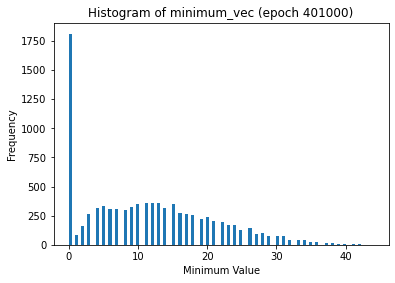

torch.Size([9216, 9, 3])


100%|██████████| 192/192 [00:07<00:00, 24.30it/s]


count    9216.000000
mean       12.304796
std         9.519246
min         0.000000
25%         4.000000
50%        11.000000
75%        19.000000
max        46.000000
dtype: float64


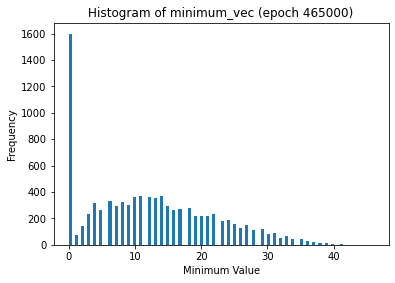

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
# ([35, 10000, 3, 9, 3])
train_attrs_one_panel = einops.rearrange(train_attrs,
        'class B p pos attr -> class (B p) pos attr', pos=9, attr=3, p=3)
print(train_attrs_one_panel.shape)
# train_attrs_one_panel.shape # (batch, 3, 9, 3)
for epochi in [0, 100, 200, 300, 400, -1]:
    attr_one_panel = einops.rearrange(sample_all[epochi], 
            'b attr (row h) (p w) -> (b row p) (h w) attr', row=3, p=3)
    print(attr_one_panel.shape) # (batch*3, 3, 9, 3)
#     raise ValueError
    minL1dist_mat = []
    minimum_vec = []
    batchsize = 48 # cannot be larger, otherwise OOM
    for i in trange(0,len(attr_one_panel),batchsize):
        L1dist = (train_attrs_one_panel[None,] - 
                  attr_one_panel[i:i+batchsize].to(device)[:,None,None]).abs().sum(dim=(-1,-2))
        minL1dist = L1dist.min(dim=-1).values
        minimum = minL1dist.min(dim=-1).values
        minL1dist_mat.append(minL1dist)
        minimum_vec.append(minimum)

    minL1dist_mat = torch.concatenate(minL1dist_mat, dim=0).cpu() # (3 * sampleN, 35)
    minimum_vec = torch.concatenate(minimum_vec, dim=0).cpu() # (3 * sampleN,)
    # print basic statistics of minimum_vec using pandas
    print(pd.Series(minimum_vec.numpy()).describe())
    plt.hist(minimum_vec, bins=100)
    plt.xlabel('Minimum Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of minimum_vec (epoch {epoch_list[epochi]})')
    plt.show()
    torch.cuda.empty_cache()

In [19]:
min_df = pd.Series(minimum_vec.numpy())

In [30]:
minL1_class_df = pd.DataFrame(minL1dist_mat.numpy())
minL1_class_df.iloc[:,20].value_counts()

20
0     422
23    338
18    324
21    322
16    320
15    313
22    309
24    300
25    294
17    290
20    287
12    285
19    280
14    272
26    271
1     260
27    252
28    234
9     227
8     223
13    220
30    212
29    209
31    203
6     202
2     197
11    195
4     175
10    173
33    168
32    154
34    136
36    132
35    128
7     104
37    101
3      96
39     80
5      78
38     73
40     71
41     55
42     45
43     45
44     44
45     26
46     21
47     16
49      8
51      8
48      7
52      3
50      3
55      2
53      2
54      1
Name: count, dtype: int64

TypeError: DataFrame.value_counts() got an unexpected keyword argument 'axis'

In [21]:
min_df.value_counts() / len(min_df)


0     0.173720
11    0.039931
14    0.039931
12    0.039605
10    0.039388
13    0.038737
6     0.035699
8     0.035590
4     0.034614
9     0.032878
15    0.032227
7     0.032118
18    0.030599
17    0.029188
5     0.028971
16    0.028863
22    0.025716
3     0.025065
20    0.023980
21    0.023763
19    0.023763
24    0.020291
23    0.019206
25    0.016819
27    0.016385
2     0.015734
26    0.013563
29    0.012912
28    0.012153
31    0.009440
30    0.008789
1     0.008355
33    0.006944
32    0.005859
34    0.004449
35    0.004449
36    0.003364
37    0.002604
38    0.001628
39    0.001085
40    0.000760
41    0.000326
42    0.000217
46    0.000109
43    0.000109
44    0.000109
Name: count, dtype: float64

In [46]:
minimum_vec.shape

torch.Size([3072])

In [45]:
minL1dist_mat.shape

torch.Size([3072, 35])

In [35]:
sample_all[0].shape

torch.Size([1024, 3, 9, 9])

In [ ]:

matching_tensors = []
for row in attr_panels:
    matching = torch.all(torch.eq(row, data), dim=(1, 2, 3)).any()
    matching_tensors.append(matching.item())

matching_tensors


In [ ]:
attr_row = attr_tsr[:,3*i_row:3*(i_row+1),:] # torch.Size([3, 3, 9])
attr = einops.rearrange(attr_row, 'attr h (p w) -> p (h w) attr', h=3,w=3,p=3) # (3, 9, 3)